# Using an example KNMI radar data file (h5) as inspiration

Given are lat/ lon coordinates of the corners, number of columns, number of rows, single pixel size and projection format description.

##### Corners:

In [1]:
lat_sw = 49.362
lon_sw = 0

lat_nw = 55.974
lon_nw = 0

lon_se = 9.009
lat_se = 48.895

lon_ne = 10.856
lat_ne = 55.389

##### Define projection from Metadata

In [2]:
projparams = {
    'proj': 'stere',
    'lat_0': 90,
    'lon_0': 0,
    'lat_ts': 60,
    'a': 6378.137,
    'b': 6356.752,
    'x_0': 0,
    'y_0':0    
}

#### Import packages

In [3]:
import pyproj
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.path as mpltPath
from shapely.geometry import Polygon
from descartes import PolygonPatch
from matplotlib.mlab import griddata
import h5py
import pandas as pd
% matplotlib inline

##### Define the custom projection (RAD)

In [4]:
p1 = pyproj.Proj(projparams)

##### Transform corner (lat/lon) to projection coordinates (x/y)

In [5]:
x_nw, y_nw = p1(0, lat_nw)
print(x_nw, y_nw)
x_sw , y_sw = p1(0, lat_sw)
print(x_sw, y_sw)
x_ne, y_ne = p1(lon_ne, lat_ne)
print(x_ne, y_ne)
x_se, y_se = p1(lon_se, lat_se)
print(x_se, y_se)

0.0 -3649.950249305968
0.0 -4415.006464486906
699.9723061714168 -3649.997949483507
699.984286636589 -4415.038230564286


##### Even though there are smaller differences I think it's reasonable to use them as linear x and y coords

In [6]:
x_data = np.linspace(x_nw, x_ne, 700)
y_data = np.linspace(y_nw, y_sw, 765)

###### Let's see if the coordinates are still in range

In [7]:
p1(x_data[-1], y_data[-1], inverse=True) # SE corner

(9.008912092597194, 48.89528100378207)

Yep looks good.

Now these can be put e.g. into a meshgrid and do our check which points are inside a defined polygon. Beware that one has to transform the new coordinates first to this projection (p1) or transfrom the existing p1 coordinates into another format.

In [8]:
xgrid, ygrid = np.meshgrid(x_data, y_data)
XY = np.dstack((xgrid, ygrid))
XY_flat = XY.reshape((-1, 2))
len(XY_flat)

535500

##### Okay let's define and transform our custom polygon to the p1 projection

In [9]:
polygon = [[51.335015, 3.371926],
[51.253118, 4.082179],
[51.441892, 4.646351],
[51.388485, 5.109778],
[51.145800, 5.774696],
[50.854157, 5.628615],
[50.752286, 5.769658],
[50.755473, 6.061819],
[50.943112, 6.102117],
[51.523453, 6.238123],
[51.826451, 6.061819],
[51.944600, 6.852668],
[53.214769, 7.260685],
[53.497372, 6.872817],
[54.603298, 4.021732],
[51.454449, 3.145250]]

In [10]:
wgs84 = pyproj.Proj(init='epsg:4326')
new_points = []
for cur_point in polygon:
    cur_lat = cur_point[0]
    cur_lon = cur_point[1]
    new_x, new_y = pyproj.transform(wgs84, p1, cur_lon, cur_lat, radians=False)
    new_points.append([new_x, new_y])
print(np.array(new_points))

[[  246.07027518 -4176.39876599]
 [  298.50149047 -4182.55215453]
 [  337.88815179 -4157.47940782]
 [  372.05798886 -4160.80827487]
 [  423.16556161 -4184.36720443]
 [  415.83673565 -4219.33208718]
 [  427.41961024 -4230.1478772 ]
 [  448.94484172 -4227.5426985 ]
 [  449.58628387 -4205.41417172]
 [  452.2124318  -4137.04648453]
 [  435.75796389 -4103.36688917]
 [  490.71515981 -4083.33189392]
 [  501.20361761 -3933.92205716]
 [  470.66499273 -3904.89838486]
 [  266.94923561 -3796.85587862]
 [  228.78195236 -4163.44348181]]


###### Let's define our path and see which points are inside

In [11]:
path = mpltPath.Path(new_points)
inside_flat = path.contains_points(XY_flat)
print(inside_flat.any())
len(inside_flat)

True


535500

#### Okay let's transform it back to our grid shape!

In [12]:
inside = inside_flat.reshape(xgrid.shape)

In [13]:
xtar, ytar = pyproj.transform(p1, wgs84, xgrid[inside], ygrid[inside])

##### Let's test it!

In [14]:
test_data = np.ones((765, 700))

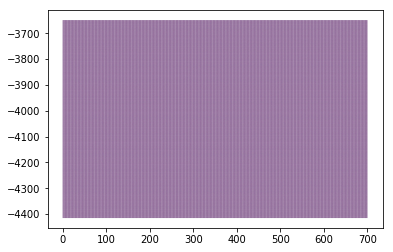

In [15]:
fig, ax = plt.subplots()
ax.scatter(xgrid, ygrid, c=test_data, s=0.1, edgecolor='')
plt.show()

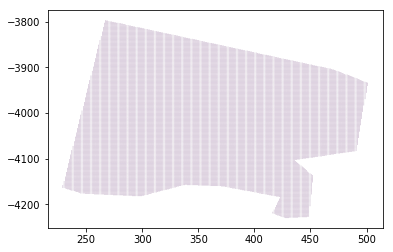

In [16]:
fig, ax = plt.subplots()
ax.scatter(xgrid[inside], ygrid[inside], c=test_data[inside], s=0.1, edgecolor='')
plt.show()

##### Cool. Seems to work. Now it's your turn!

# Update 12.02.2018

### Okay let's try some real data with the latest grid coordinates we generated.

In [17]:
KNMI_25RAC_h5_filename = './playground/RAD_NL25_RAC_MFBS_5min_201606122000_NL.h5'
loaded_file = h5py.File(KNMI_25RAC_h5_filename, 'r')
loaded_df = pd.DataFrame(loaded_file['image1']['image_data'][:])
loaded_file.close()
loaded_df.replace(65535, np.nan, inplace=True)
loaded_df = loaded_df/100  # conversion to mm
rain_data = loaded_df.as_matrix()

##### How does the data look like?

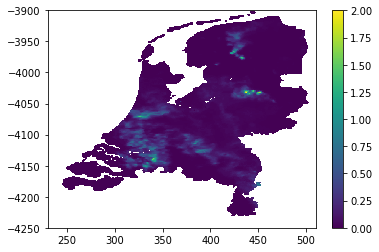

In [18]:
plt.pcolormesh(xgrid, ygrid, loaded_df, vmin=0, vmax=2)
plt.xlim([230, 510])
plt.ylim([-4250, -3900])
plt.colorbar()

Okay looks quiet cool. Lots of NaNs, zeros and some rain data.

##### In the Rotterdam area (more or less) in the original projection:

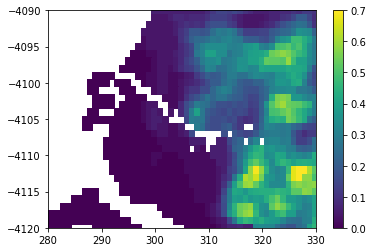

In [19]:
plt.pcolormesh(xgrid, ygrid, rain_data, vmin=0, vmax=0.7)
plt.xlim([280, 330])
plt.ylim([-4120,-4090])
plt.colorbar()

###### Datapoints only (including NaNs)

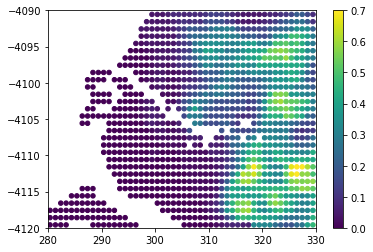

In [20]:
plt.scatter(xgrid, ygrid, c=rain_data, s=20,vmin=0.0, vmax=0.7)
plt.xlim([280, 330])
plt.ylim([-4120,-4090])
plt.colorbar()

### Let's see if we can convert the projection to another one

In [21]:
aamersfort = pyproj.Proj(init='epsg:28992')
xtar, ytar = pyproj.transform(p1, aamersfort, xgrid, ygrid)

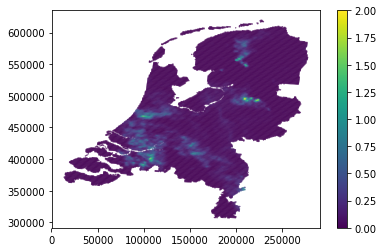

In [22]:
plt.scatter(xtar, ytar, c=loaded_df, s=0.1, vmin=0, vmax=2)
plt.colorbar()

##### Okay quiet cool. Data seems to be (visually at) not have changed. Just a diagonal pattern caused by the projection.

#### Let's define a custom polygon in the rotterdam area (rectangle) in the new projection.

In [23]:
polygon = [[447163.52438479, 55215.7025986135], 
           [447163.52438479, 101265.924442491], 
           [428561.131189619, 101265.924442491], 
           [ 428561.131189619, 55215.7025986135]]
polygon_inv = [[55215.7025986135, 447163.52438479], 
           [101265.924442491, 447163.52438479], 
           [101265.924442491, 428561.131189619], 
           [55215.7025986135, 428561.131189619],
              [55215.7025986135, 447163.52438479]]

##### Let's transform the polygon points to the p1 (original in h5) defined projection.

In [24]:
new_points = []
for cur_point in polygon:
    cur_lat = cur_point[0]
    cur_lon = cur_point[1]
    new_x, new_y = pyproj.transform(aamersfort, p1, cur_lon, cur_lat, )
    new_points.append([new_x, new_y])
print(np.array(new_points))

[[  281.69491403 -4096.04271531]
 [  329.56192979 -4091.72724549]
 [  331.32995824 -4111.07093716]
 [  283.41511001 -4115.39061782]]


##### And apply the same procedure as with the old polygon...

In [25]:
path = mpltPath.Path(new_points)
inside_flat = path.contains_points(XY_flat)
print(inside_flat.any())
inside = inside_flat.reshape(xgrid.shape)

True


##### How does the defined area look like in the original projection?

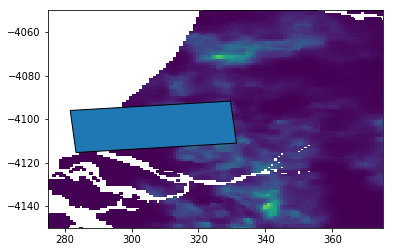

In [26]:
poly = Polygon(new_points)
fig = plt.figure()
ax = fig.add_subplot(111)
polyp = PolygonPatch(poly)
ax.add_patch(polyp)
ax.pcolormesh(xgrid,ygrid, rain_data, vmin=0, vmax=2)
plt.ylim([-4150, -4050])
plt.xlim([275, 375])
plt.show()

##### An how in the new projection?

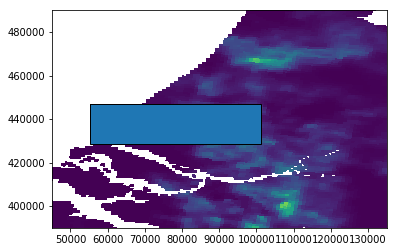

In [27]:
poly = Polygon(polygon_inv)
#plot original figure
fig = plt.figure()
ax = fig.add_subplot(111)
polyp = PolygonPatch(poly)
ax.add_patch(polyp)
ax.pcolormesh(xtar,ytar, rain_data, vmin=0, vmax=2)
plt.ylim([390000, 490000])
plt.xlim([45000, 135000])
plt.show()

##### Let's look at the data

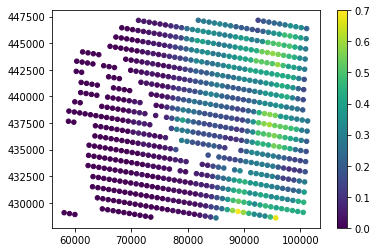

In [28]:
xtar_selection, ytar_selection = pyproj.transform(p1, aamersfort, xgrid[inside], ygrid[inside])
plt.scatter(xtar_selection, ytar_selection, c=rain_data[inside], s=20,vmin=0.0, vmax=0.7)
plt.colorbar()

##### Since we have an irregularly shaped grid we should think about putting it into a uniform grid. We achieve this by interpolating.

In [29]:
xi = np.arange(55215.7025986135+1000,101265.924442491,1000)
yi = np.arange(428561.131189619+1000,447163.52438479,1000)
zi = griddata(xtar_selection,ytar_selection,rain_data[inside],xi,yi, 'linear')

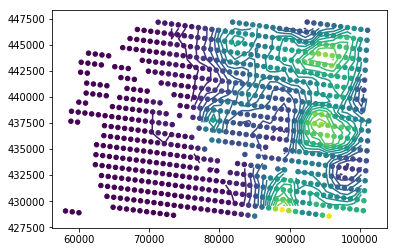

In [30]:
plt.contour(xi,yi,zi,15, vmin=0, vmax=0.7)
plt.scatter(xtar_selection, ytar_selection,c=rain_data[inside], marker='o',s=20)

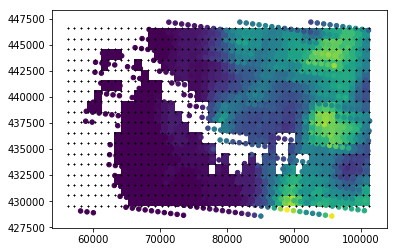

In [31]:
x_new_grid, y_new_grid = np.meshgrid(xi, yi)
#plt.contourf(xi,yi,zi,15, vmin=0, vmax=0.7)
plt.pcolor(x_new_grid,y_new_grid,zi, vmin=0, vmax=0.7)
plt.scatter(xtar_selection,ytar_selection,c=rain_data[inside], marker='o',s=20)
plt.scatter(x_new_grid,y_new_grid, c='k', marker='x', s=1)

###### Since the griddata interpolation is based on triangulation and only considers data inside the convex hull, we can consider to ignore the NaN values.

In [32]:
rain_data_sel = rain_data[inside]
zi = griddata(xtar_selection[~np.isnan(rain_data_sel)],ytar_selection[~np.isnan(rain_data_sel)],rain_data_sel[~np.isnan(rain_data_sel)],xi,yi, 'linear')

##### So how does it look now?

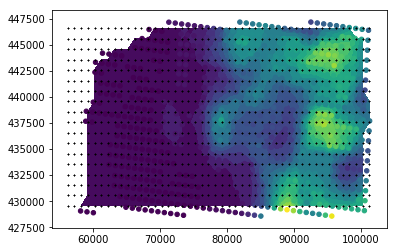

In [33]:
plt.contourf(xi,yi,zi,15, vmin=0, vmax=0.7)
plt.scatter(xtar_selection,ytar_selection,c=rain_data_sel, marker='o',s=20)
plt.scatter(x_new_grid,y_new_grid, c='k', marker='x', s=1)

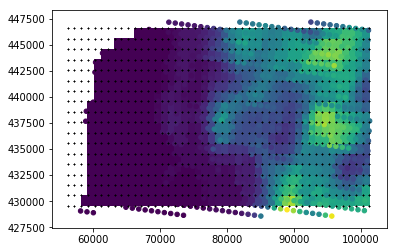

In [34]:
x_new_grid, y_new_grid = np.meshgrid(xi, yi)
#plt.contourf(xi,yi,zi,15, vmin=0, vmax=0.7)
plt.pcolor(x_new_grid,y_new_grid,zi, vmin=0, vmax=0.7)
plt.scatter(xtar[inside],ytar[inside],c=rain_data[inside], marker='o',s=20)
plt.scatter(x_new_grid,y_new_grid, c='k', marker='x', s=1)

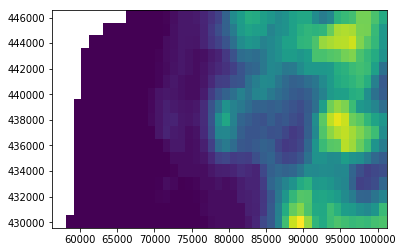

In [35]:
plt.pcolor(xi,yi,zi)

##### This way we don't lose data due to the triangulation of NaN values @ around the river.